# Introduction #

Fraud has become an ever-rising concern, especially in the UK with PWC reporting that in 2022, fraudsters stole £1.2bn __(PWC, 2023)__. With an alarmingly high figure, the need for a machine learning model to accurately identify fraudulent transactions will not only protect customers from becoming victims of fraud, but also reduce the amount financial instituations e.g. insurance companies needing to pay comepensation to these victims.

Kaggle provided a dataset of just over a million records of transactions detailing the type of transaction e.g. payment, cash outgoing, transfers; the transaction amount, the source account name, the old balance of the source account, the new balance of the source account, the destination account name, the old balance of the destination account, the new balance of the destination account, a binary flag on whether the transaction was fraudulent or not, and a flag on whether the transaction was marked as fraudulent or not __(Lopez-Rojas, 2016)__.

The data was extracted from Kaggle and contained approximately 630,000 transactions of varying types, e.g. transfers, cash out, cash in etc. Fraudulent transactions were marked with a binary flag in this data set (1).       


**PWC. (2023). UK Banking Fraud Sentiment Index. [online] Available at: https://www.pwc.co.uk/forensic-services/assets/documents/uk-banking-fraud-sentiment-index.pdf [Accessed 18 Oct. 2024].**

**Lopez-Rojas, E. (2016). Synthetic Financial Datasets For Fraud Detection. [online] Kaggle.com. Available at: https://www.kaggle.com/datasets/ealaxi/paysim1 [Accessed 18 Oct. 2024].**

‌
__Objective: Briefly state the purpose of the project, e.g., fraud detection using machine learning, and provide the problem context.
Data Overview: Describe the data source, features, target variable, and any preprocessing that was initially done.
Outline of Steps Taken: Briefly mention the methodology and key stages (e.g., data exploration, model selection, tuning). Include this to orient the reader to the sections they’ll see.__
‌

In [11]:
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier

# Code: Show code for importing libraries, loading data, and visualizing initial data distributions.

### Helper Functions

In [18]:
def create_scatter(x_train, y_train, x_test, y_test):
    plt.figure(figsize=(20,10))
    colourMap = colors.ListedColormap(['green', 'red'])

    plt.scatter(x_train["amount"], x_train["oldbalanceOrg"], c=y_train, cmap=colourMap, alpha = 0.5, label="Train", marker="o" )
    plt.scatter(x_test["amount"], x_test["oldbalanceOrg"], c=y_test, cmap=colourMap, alpha = 0.5, label="Test", marker="x")

    plt.ylabel("Original Balance of Source Account")
    plt.xlabel("Amount of Transaction")

    plt.yscale('log')
    plt.xscale('log')

    plt.legend() 
    redPatch = mpatches.Patch(color='green', label='Not Fraudulent')
    greenpatch = mpatches.Patch(color='red', label='Fraudulent')
        
    ax = plt.gca()
    leg = ax.get_legend()
    plt.legend(handles=[leg.legend_handles[0],leg.legend_handles[1], redPatch, greenpatch])

    plt.plot()

# Extract outliers where the amount transferred is substantially greater than the original balance of the source account
def extract_outliers_high(dataset, threshold):
    outliers = dataset[dataset['amount'] > threshold * dataset['oldbalanceOrg']]
    return outliers

# Extract outliers where the amount transferred is substantially less than the original balance of the source account
def extract_outliers_low(dataset, threshold):
    outliers = dataset[dataset['amount'] < dataset['oldbalanceOrg'] / threshold]
    return outliers


# 2. Data Exploration and Preprocessing
## Subsection A: Initial Data Exploration


In [2]:
# Fraud detection in bank accounts
dataset = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [6]:
initial_data = dataset[:2000]

In [7]:
# input
x = initial_data.drop("isFraud", axis='columns')

# output
y = initial_data["isFraud"]

# Remove obselete columns
x = x.drop(["nameOrig", "nameDest"], axis="columns")

In [8]:
# Split data into training and testing sets 
x_train,x_test,y_train,y_test = train_test_split(x,y)

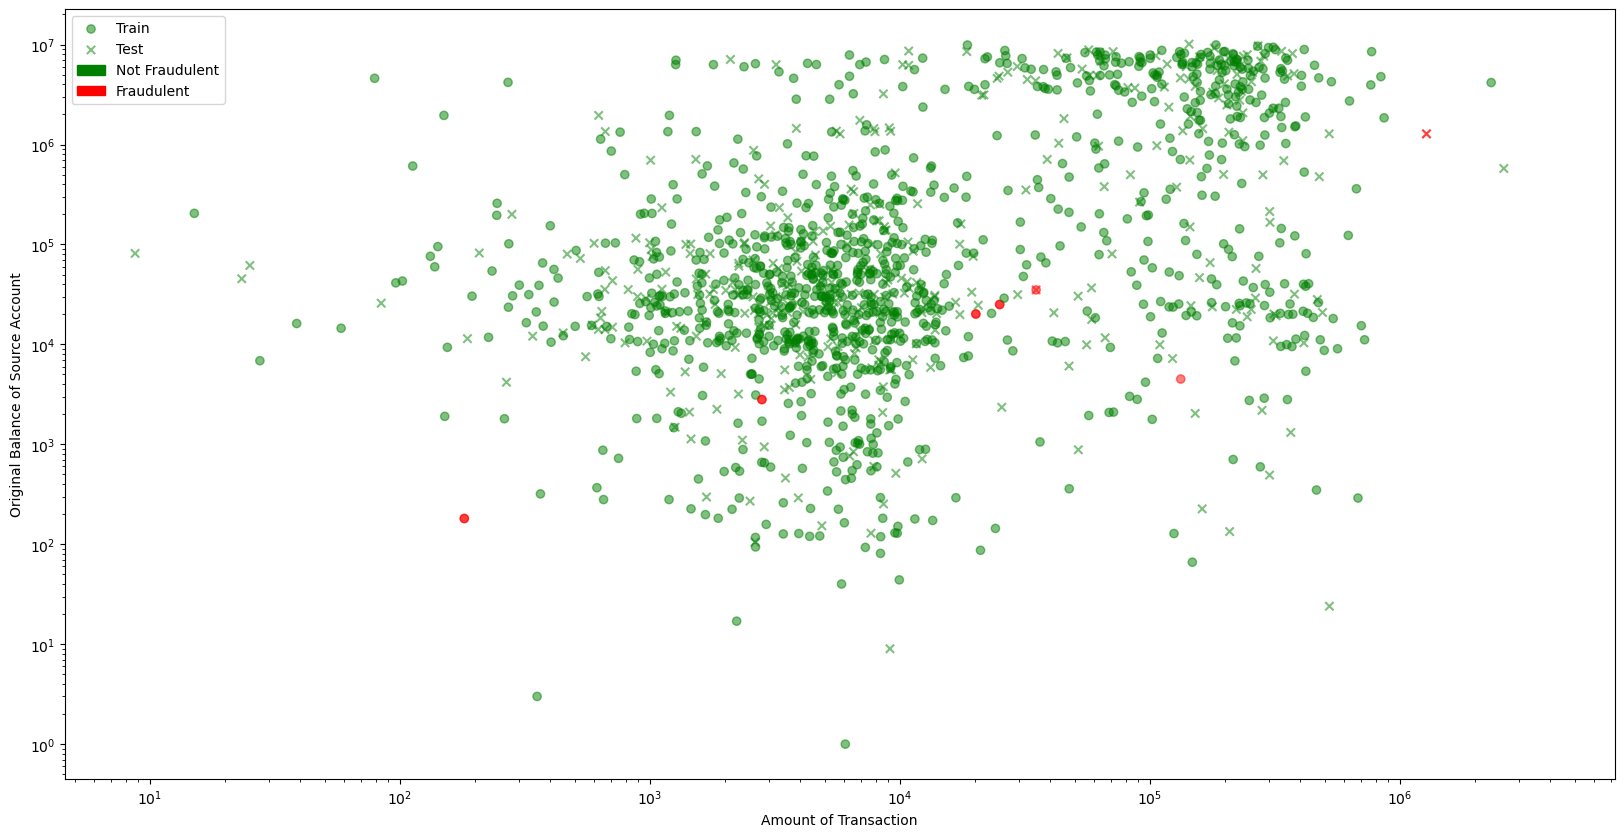

In [16]:
create_scatter(x_train, y_train, x_test, y_test)

***Figure 1: Initial State of Data***


Initial exploration of the dataset revealed that in the intial sample (2000 rows) there was a significant class imbalance with only 7.7% of the sample being fraudulent. Model training on this sample lead to incredible accuracy, with the model achieving accuracy scores of 100% and 99% in the train and test data respectively.

Upon further analysis, this result was strongly accredited to the fact that there was such a low number of fraudulent cases to train the data on, and so the model likely became overfitted to the non-fraudulent class, furthermore, because only 7.7% of the sample was fraudulent, the model could predict the transaction was non-fraudulent and be correct 92.3% of the time.

To further reinforce this assumption, a confusion matrix was constructed and illustrated that there were 493 true negatives (i.e. non-fraudulent transactions), 2 true positives, 2 false negatives and 3 false positives, suggesting that of the non-fraudulent transactions, the model was good at predicting these, but, relative to the class size, performed poorly when predicting how many transactions were actually fraudulent.

To consolidate the findings above, the model's F1 score on this sample was 0.44, highlighting its limited effectiveness, particularly in identifying the minority class.


//////__Figures: Add figures here for initial exploration (e.g., class distribution plot, transaction amount distribution) with descriptions in markdown.__



## Subsection B: Balancing the Dataset and Enhancing Features
Markdown: Describe how u are making the dataset more balanced and also why you are manually adding more outliers

Code: Provide code for cleaning, transforming, or encoding features, if necessary.
Figures: If any transformations or engineered features benefit from visualization (e.g., correlation matrix or a plot showing engineered features), add those here.


In [23]:
fraudulent_data = dataset[dataset['isFraud'] == 1]
non_fraudulent_data = dataset[dataset['isFraud'] == 0]

# 30% of total data set is fraudulent
fraudulent_data = fraudulent_data[:1050]

#70% of total data set is non-fraudulent
non_fraudulent_data = non_fraudulent_data[:2450]

# 3500 total data points
proportionate_dataset = pd.concat([fraudulent_data, non_fraudulent_data],ignore_index=True)

proportionate_dataset = proportionate_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# proportionate_dataset = dataset[:3000] # here is the line that drops f1 score


In [24]:
fraudulent_data = dataset[dataset['isFraud'] == 1]

In [25]:
# Extract outliers from all fraudulent data
fraudulent_outliers_hi = extract_outliers_high(fraudulent_data, 1.5)
fraudulent_outliers_lo = extract_outliers_low(fraudulent_data, 1.5)

In [26]:
train_outliers_hi = fraudulent_outliers_hi[len(fraudulent_outliers_hi)//2:]
test_outliers_hi = fraudulent_outliers_hi[:len(fraudulent_outliers_hi)//2]

train_outliers_lo = fraudulent_outliers_lo[len(fraudulent_outliers_lo)//2:]
test_outliers_lo = fraudulent_outliers_lo[:len(fraudulent_outliers_lo)//2]

In [30]:
rows_to_drop = proportionate_dataset[proportionate_dataset['isFraud'] == 1].index

rows_to_drop = rows_to_drop[:len(fraudulent_outliers_hi) + len(fraudulent_outliers_lo)]

# Drop rows_to_drop number of rows from the dataset fed into model
proportionate_dataset2 = proportionate_dataset.drop(rows_to_drop)

# Evenly split dataset into training and testing sets
train_proportionate_dataset = proportionate_dataset2[len(proportionate_dataset2)//2:]
test_proportionate_dataset = proportionate_dataset2[:len(proportionate_dataset2)//2]


In [31]:

# Create even split of t rain and test data with equal numbers of outliers
train_outliers = pd.concat([train_outliers_hi, train_outliers_lo],ignore_index=True)
test_outliers = pd.concat([test_outliers_hi, test_outliers_lo],ignore_index=True)


In [32]:

# Evenly split outliers into training and testing sets
train_data = pd.concat([train_proportionate_dataset, train_outliers],ignore_index=True)
test_data = pd.concat([test_proportionate_dataset, test_outliers],ignore_index=True)


In [33]:
# Split the data intended for training into input and output
#input
x_for_train = train_data.drop("isFraud", axis='columns')

#output
y_for_train = train_data["isFraud"]

# Remove obselete columns
x_for_train = x_for_train.drop(["nameOrig", "nameDest"], axis="columns")

x_train1,x_test1,y_train1,y_test1 = train_test_split(x_for_train,y_for_train, stratify=y_for_train)

In [34]:
# Split the data intended for testing into input and output
#input
x_for_test = test_data.drop("isFraud", axis='columns')

#output
y_for_test = test_data["isFraud"]

# Remove obselete columns
x_for_test = x_for_test.drop(["nameOrig", "nameDest"], axis="columns")

x_train2,x_test2,y_train2,y_test2 = train_test_split(x_for_test,y_for_test, stratify=y_for_test)

In [36]:
# Join the two sets of splits 
x_train = pd.concat([x_train1, x_train2],ignore_index=True)
x_test = pd.concat([x_test1, x_test2],ignore_index=True)
y_train = pd.concat([y_train1, y_train2],ignore_index=True)
y_test = pd.concat([y_test1, y_test2],ignore_index=True)

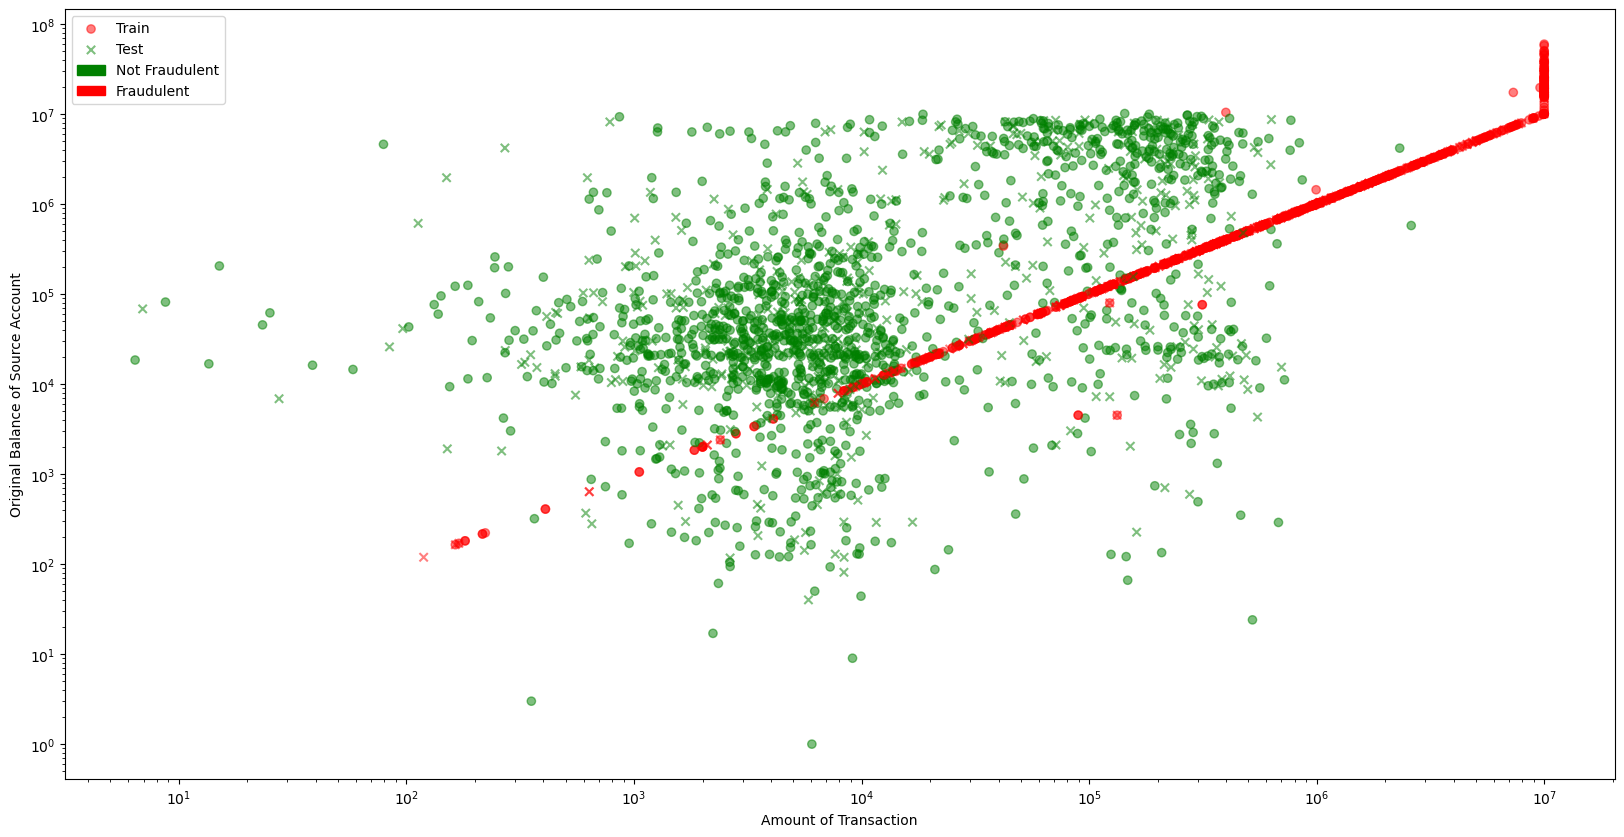

In [37]:
create_scatter(x_train, y_train, x_test, y_test)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Cross-Validation Score: 0.9942842602689931
Train data accuracy:  0.9954268292682927
Test data accuracy:  0.9954337899543378
Number of True Negatives: 611.000
Number of True Positives: 261.000
Number of False Negatives: 2.000
Number of False Positives: 2.000


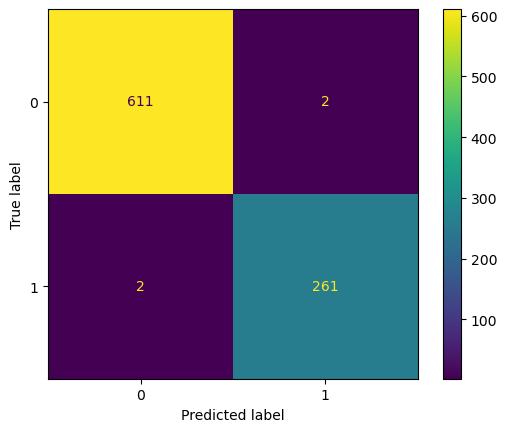

In [42]:
label_encoder = LabelEncoder()

# transform needed to convert string vals in CSV column to numbers as model cannot train on strings
x_train['type'] = label_encoder.fit_transform(x_train['type'])

# transform used again but NOT fit_transform because you want to test on the same transformation done on train set
x_test['type'] = label_encoder.transform(x_test['type'])

param_grid = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                           param_grid=param_grid,
                           cv=5, 
                           scoring='accuracy')

grid_search_dt.fit(x_train, y_train)

print("Best Parameters:", grid_search_dt.best_params_)
print("Best Cross-Validation Score:", grid_search_dt.best_score_)

# Get best decision tree model
dt_model = grid_search_dt.best_estimator_

# Prediction on train data
y_train_prediction = dt_model.predict(x_train)

# Prediction on test data
y_test_prediction = dt_model.predict(x_test) 

# Generate accuracy scores for train and test data
y_test_accuracy_score = accuracy_score(y_test, y_test_prediction)
y_train_accuracy_score = accuracy_score(y_train, y_train_prediction)

# Print accuracy scores for train and test data
print("Train data accuracy: ", y_train_accuracy_score)
print("Test data accuracy: ", y_test_accuracy_score)

# Generate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,y_test_prediction, labels=dt_model.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=dt_model.classes_)

# Display confusion matrix
disp.plot()

# Print confusion matrix values
print("Number of True Negatives: {:.3f}".format(confusion_matrix[0,0]))
print("Number of True Positives: {:.3f}".format(confusion_matrix[1,1]))
print("Number of False Negatives: {:.3f}".format(confusion_matrix[1,0]))
print("Number of False Positives: {:.3f}".format(confusion_matrix[0,1]))

# 3. Model Selection and Baseline Model
## Subsection A: Baseline Model Setup
Markdown: Explain the logic behind selecting the baseline model and any specific configurations (e.g., initial hyperparameters, splitting strategy).
Code: Include code for splitting the data and training a baseline model, like a simple decision tree.
Figures: Show initial performance metrics and confusion matrix for the baseline. This helps establish a point of comparison.

## Subsection B: Model Iteration Process
Markdown: Describe the thought process for improving the model (e.g., adjusting hyperparameters, changing the model type). List the key changes made between iterations and why.
Code: Instead of incremental code changes, show the final optimized model code here for clarity and conciseness.
Figures: Include figures for each major model iteration (e.g., ROC curve, feature importance plot) with markdown explanations.



# 4. Final Model Evaluation
## Subsection A: Performance Metrics

## Subsection B: Interpretation of Results
Markdown: Discuss the practical implications of your model’s performance, any observed limitations, and potential improvements or further work.



# 5. Conclusions and Next Steps
Summary of Findings: Summarize key takeaways and performance of the final model in relation to the project’s objectives.
Future Work: Suggest ways the project could be expanded (e.g., exploring different models, adding more data, or handling class imbalance).